In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.optimize import fmin_tnc

#### Collaborative Filtering Cost Function
<img src="math 1.svg" align="left"/>

<img src="math 2.svg" align="left"/>

<img src="math 3.svg" align="left"/>

In [2]:
def cost_func(params, Y, R, num_users, num_movies, num_features, lambda_):
    '''
    "Collaborative filtering cost function"
    
    params : 'Unrolled' weight vector.
    Y (num_movies x num_users) : Movie ratings (0-5).
    R (num_movies x num_users) : R(i, j) == 1, if user 'j' gives rating on movie 'i'.
    lambda_ : Regularization param.
    
    return : Cost, Gradient.
    '''
    # Rolling params into X and Theta
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    # initializing
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # Cost
    J = 0.5 * np.sum((((X @ Theta.T) - Y) ** 2) * R)
    J += (lambda_ / 2) * (np.sum(Theta ** 2) + np.sum(X ** 2))
    
    # Gradient
    X_grad = ((((X @ Theta.T) - Y) * R) @ Theta) + (lambda_ * X)
    Theta_grad = ((((X @ Theta.T) - Y) * R).T @ X) + (lambda_ * Theta)
    
    # Unrolling gradients
    grad = np.vstack((X_grad.reshape(-1, 1), Theta_grad.reshape(-1, 1)))
    
    return J, grad

In [3]:
def normalize_ratings(Y, R):
    '''
    "Preprocess data by subtracting mean rating from each movie (every row)"
    
    return : Ynorm (num_movies x num_users)
             Ymean (num_movies x 1)
    '''
    num_movies = Y.shape[0]
    Ymean = np.zeros((num_movies, 1))
    Ynorm = np.zeros(Y.shape)
    
    for i in range(num_movies):
        Ymean[i] = np.sum(Y[i, :]) / np.count_nonzero(R[i, :])
        Ynorm[i, R[i, :]==1] = Y[i, R[i, :]==1] - Ymean[i]
        
    return Ynorm, Ymean

#### Example

In [4]:
mat = loadmat('..\datasets\ex8_movies.mat')
Y = mat['Y']  # containing ratings (1-5) of 1682 movies on 943 user
R = mat['R']  # R(i,j) = 1 if and only if user j give rating to movie i
print(Y.shape)
print(R.shape)

(1682, 943)
(1682, 943)


In [5]:
num_movies = Y.shape[0]

Text(33.0, 0.5, 'Movies')

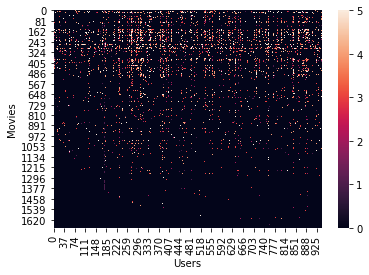

In [6]:
# Visualizing the rating matrix
sns.heatmap(Y)
plt.xlabel('Users')
plt.ylabel('Movies')

In [7]:
# Movie list
movie_list = open('..\datasets\movie_ids.txt', 'r').read().split('\n')[:-1]
movie_list

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35

In [8]:
'''
Before training the collaborative filtering, we first add rating 
that correspons to a new user.
'''
my_ratings = np.zeros((num_movies, 1))

my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Rated {int(my_ratings[i])} for index {movie_list[i]}')

New user ratings:

Rated 4 for index 1 Toy Story (1995)
Rated 3 for index 7 Twelve Monkeys (1995)
Rated 5 for index 12 Usual Suspects, The (1995)
Rated 4 for index 54 Outbreak (1995)
Rated 5 for index 64 Shawshank Redemption, The (1994)
Rated 3 for index 66 While You Were Sleeping (1995)
Rated 5 for index 69 Forrest Gump (1994)
Rated 2 for index 98 Silence of the Lambs, The (1991)
Rated 4 for index 183 Alien (1979)
Rated 5 for index 226 Die Hard 2 (1990)
Rated 5 for index 355 Sphere (1998)


In [9]:
# Add new user ratings to Y and R
Y = np.hstack((my_ratings, Y))
R = np.hstack(((my_ratings != 0).astype(int), R))
print(Y.shape)
print(R.shape)

(1682, 944)
(1682, 944)


In [10]:
# Normalize ratings
Ynorm, Ymean = normalize_ratings(Y, R)
print(Ynorm.shape)
print(Ymean.shape)

(1682, 944)
(1682, 1)


#### Training using an advanced optimization algorithm

In [11]:
num_users = Y.shape[1]
num_features = 10    # 10 different types of movies (Romantic, Kids, War, Animations, ...)

# Initialize parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_params = np.vstack((X.reshape(-1, 1), Theta.reshape(-1, 1)))
lambda_ = 10

# Training
out = fmin_tnc(func=cost_func, x0=initial_params, args=(Ynorm, R, num_users, num_movies, num_features, lambda_))
final_params = out[0]

In [12]:
# unfolding params
X = final_params[:num_movies*num_features].reshape(num_movies, num_features)
Theta = final_params[num_movies*num_features:].reshape(num_users, num_features)

In [13]:
# Predict Rating
p = X @ Theta.T
my_predictions = p[:, 0][:, np.newaxis] + Ymean

In [14]:
def get_name(s):
    name = ''
    for word in s.split()[1:]:
        name += word + ' '
    return name[:-1]

In [19]:
df = pd.DataFrame(np.hstack((np.array(list(map(get_name, movie_list)))[:, np.newaxis], my_predictions)))
df.columns = ['movies', 'ratings']
df.head()

,movies,ratings
0,Toy Story (1995),3.9805035210566184
1,GoldenEye (1995),3.332113908010511
2,Four Rooms (1995),3.278681050583285
3,Get Shorty (1995),3.589478117093168
4,Copycat (1995),3.3931931067961383


In [20]:
# Recommendations for new user
df.sort_values(by='ratings', ascending=False, inplace=True)
df.head(10)

,movies,ratings
1121,They Made Me a Criminal (1939),5.000000081919991
813,"Great Day in Harlem, A (1994)",5.0000000175436385
1499,Santa with Muscles (1996),5.000000005100762
1188,Prefontaine (1997),5.0000000004122
1652,Entertaining Angels: The Dorothy Day Story (1996),5.000000000001636
1200,Marlene Dietrich: Shadow and Light (1996),5.000000000000331
1535,Aiqing wansui (1994),4.999999999997355
1466,"Saint of Fort Washington, The (1993)",4.999999998367007
1598,Someone Else's America (1995),4.999999992372097
1292,Star Kid (1997),4.999999960539331
